In [62]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline
import caffe
import os
import lmdb
import cv2
from sklearn.preprocessing import LabelEncoder

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

local_model_path = '../models'
# local_net_path = '../net/nado_flow'
# local_data_path = '../data_motion'
local_data_path = '../data/data_flow_norm_rep'
frames_root = '~/datasets/RatSI/video_frames'
# deploy_proto = os.path.join(local_net_path, 'deploy.prototxt')
# mean_data = os.path.join(local_data_path, 'ratsi_mean.binaryproto')

# load labels
labels_file = os.path.join(local_data_path, 'labels.txt')
labels = np.loadtxt(labels_file, str, delimiter='\t')
le = LabelEncoder().fit(labels)

In [44]:
netproto = '/home/malte/rbr_cnn/rtracker_caffe/net/vgg-m-rgb-lstm/deploy_lstm.prototxt'
weights = '/home/malte/Documents/Results/2017-03-30_VGG-M-RGB-LSTM/exp06/vgg-m-rgb-lstm_iter_87490.caffemodel'

caffe.set_mode_gpu()
caffe.set_device(0)
net = caffe.Net(netproto, weights, caffe.TEST)

In [45]:
def initialize_transformer(image_mean):
    shape = (1*10, 3, 224, 224)
    transformer = caffe.io.Transformer({'data': shape})
    channel_mean = np.zeros((3,224,224))
    for channel_index, mean_val in enumerate(image_mean):
        channel_mean[channel_index, ...] = mean_val
    transformer.set_mean('data', channel_mean)
    transformer.set_raw_scale('data', 255)
    transformer.set_channel_swap('data', (2, 1, 0))
    transformer.set_transpose('data', (2, 0, 1))
#     transformer.set_is_flow('data', is_flow)
    return transformer


ratsi_mean_RGB = np.ones((3,1,1)) * 40

transformer_RGB = initialize_transformer(ratsi_mean_RGB)

In [142]:
#classify video with LSTM model
def classify_video(frames, net, transformer):
    clip_length = 10
    offset = 10
    input_images = []
    for im in frames:
        input_im = caffe.io.load_image(im)
        if (input_im.shape[0] < 256):
            input_im = caffe.io.resize_image(input_im, (256,256))
        input_images.append(input_im)
    vid_length = len(input_images)
    input_data = []
    for i in range(0,vid_length,offset):
        if (i + clip_length) < vid_length:
            input_data.extend(input_images[i:i+clip_length])
        else:  #video may not be divisible by clip_length
            input_data.extend(input_images[-clip_length:])
    output_predictions = np.zeros((len(input_data), 6))
    for i in range(0,len(input_data),clip_length):
        clip_input = input_data[i:i+clip_length]
        clip_input = caffe.io.oversample(clip_input,[224,224]) # creates 10 crops
        clip_clip_markers = np.ones((clip_input.shape[0],1,1,1))
        clip_clip_markers[0:10,:,:,:] = 0
        caffe_in = np.zeros(np.array(clip_input.shape)[[0,3,1,2]], dtype=np.float32)
        for ix, inputs in enumerate(clip_input):
            caffe_in[ix] = transformer.preprocess('data',inputs)
        out = net.forward_all(data=caffe_in, clip_marker=np.array(clip_clip_markers))
        output_predictions[i:i+clip_length] = np.mean(out['prob'],1)
#     return np.mean(output_predictions,0).argmax(), output_predictions
    return output_predictions[-1,:].argmax(), output_predictions

In [143]:
# test data
test_frames_list = os.path.join(local_data_path, 'test.txt')
with open(test_frames_list, 'r') as fh:
    test_frames = fh.read().splitlines()
test_frames = map(lambda s: s.split(' '), test_frames)

In [154]:
idx = np.random.randint(0, len(test_frames) - 1)
vidname, start_frame, y_true = test_frames[idx]
start_frame = int(start_frame)
y_true = int(y_true)

RGB_frames = [os.path.expanduser(os.path.join(frames_root, vidname, 'frame_{:08d}.jpg'.format(i))) 
              for i in range(start_frame, start_frame + 10)]

print vidname, start_frame, y_true

Observation07 5466 4


In [155]:
pred, prob = classify_video(RGB_frames, net, transformer_RGB)

print 'Predicted class:', pred, labels[pred]
print 'True class:', y_true, labels[y_true]
print

# sort top five predictions from softmax output
top_inds = prob.mean(axis=0).argsort()[::-1]  # reverse sort and take five largest items

print 'Top 5:'
zip(prob.mean(axis=0)[top_inds], labels[top_inds])

Predicted class: 4 Solitary
True class: 4 Solitary

Top 5:


[(0.36008207499980927, 'Approaching'),
 (0.34063016772270205, 'Solitary'),
 (0.22318454086780548, 'Moving away'),
 (0.061396157369017601, 'Following'),
 (0.014307019021362066, 'Contact'),
 (0.00040004376787692306, 'Uncertain')]

In [156]:
print 'xviewer', RGB_frames[0]

xviewer /home/malte/datasets/RatSI/video_frames/Observation07/frame_00005466.jpg


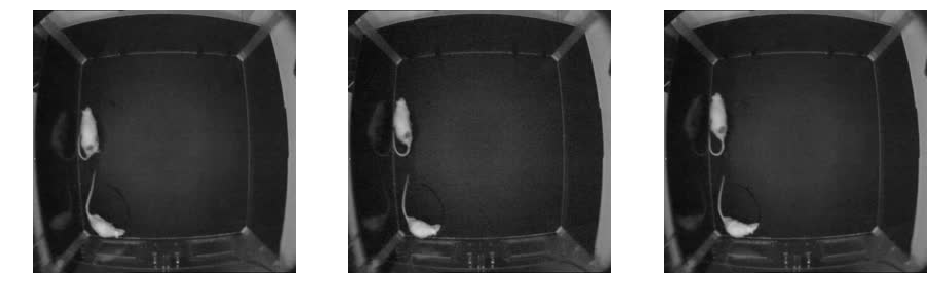

In [157]:
im0 = caffe.io.load_image(RGB_frames[0])
im1 = caffe.io.load_image(RGB_frames[5])
im2 = caffe.io.load_image(RGB_frames[9])

fig, axs = plt.subplots(1, 3, figsize=(16,8))

axs[0].imshow(im0); axs[0].axis('off');
axs[1].imshow(im1); axs[1].axis('off');
axs[2].imshow(im2); axs[2].axis('off');

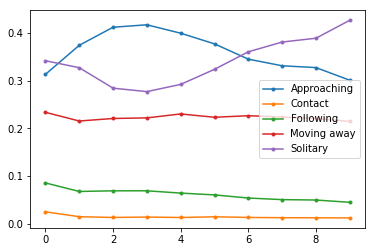

In [158]:
fig = plt.figure(figsize=(6,4))
plt.plot(prob[:, :5], marker='.')
plt.legend(labels)

---

### Exploring layers

In [103]:
# for each layer, show the output shape
print 'Layer output shapes:'
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)
    
print
print 'Layer parameter shapes:'
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)

Layer output shapes:
data	(100, 3, 224, 224)
clip_marker	(100, 1, 1, 1)
conv1	(100, 96, 109, 109)
norm1	(100, 96, 109, 109)
pool1	(100, 96, 54, 54)
conv2	(100, 256, 26, 26)
norm2	(100, 256, 26, 26)
pool2	(100, 256, 13, 13)
conv3	(100, 512, 13, 13)
conv4	(100, 512, 13, 13)
conv5	(100, 256, 13, 13)
pool5	(100, 256, 6, 6)
fc6	(100, 2048)
fc6-reshape	(10, 10, 2048)
reshape-cm	(10, 10)
lstm1	(10, 10, 512)
lstm1-drop	(10, 10, 512)
fc8-final	(10, 10, 6)
prob	(10, 10, 6)

Layer parameter shapes:
conv1	(96, 3, 7, 7) (96,)
conv2	(256, 96, 5, 5) (256,)
conv3	(512, 256, 3, 3) (512,)
conv4	(512, 512, 3, 3) (512,)
conv5_ratsi	(256, 512, 3, 3) (256,)
fc6_ratsi	(2048, 9216) (2048,)
lstm1	(2048, 2048) (2048,)
fc8-final	(6, 512) (6,)


(21, 672)


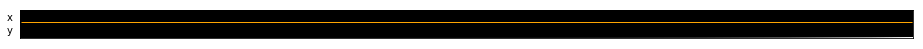

In [104]:
def vis_temporal_channels(data, spatial_mean=False):
    
    if spatial_mean:
        data = data.mean(axis=3).mean(axis=2).T
    
        data_alt = np.empty(data.shape, data.dtype)
        data_alt[::2] = data[:data.shape[0]/2]
        data_alt[1::2] = data[data.shape[0]/2:]
        
        data = data_alt
    else:       
        data_alt = np.empty((data.shape[1]*data.shape[3], data.shape[0] * data.shape[2]), data.dtype)
        K = data.shape[2]
        L = data.shape[1]
        
        for flt in range(data.shape[0]):
            for l in range(L/2):
                # x
                data_alt[l*K:(l+1)*K, flt*K:(flt+1)*K] = data[flt, l*2, :, :]
                # y
                data_alt[(l+L/2)*K:(l+L/2+1)*K, flt*K:(flt+1)*K] = data[flt, l*2+1, :, :]
        
        data = data_alt
    
    print data.shape
    plt.figure(figsize=(16,8))
    plt.imshow(data); #plt.axis('off')
    
    plt.hlines(data.shape[0]/2-1.5, 0, data.shape[1]-1, linewidth=1, colors='orange')
    
    ax = plt.gca()
    ax.set_yticks([data.shape[0]/4-1, 3*data.shape[0]/4-1])
    ax.set_yticklabels(['x','y'])
    ax.tick_params('both', labelleft=True, left=False, bottom=False, labelbottom=False)
    
    
filters = net.params['conv1'][0].data
vis_temporal_channels(filters, spatial_mean=False)

In [105]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data.squeeze()); plt.axis('off')

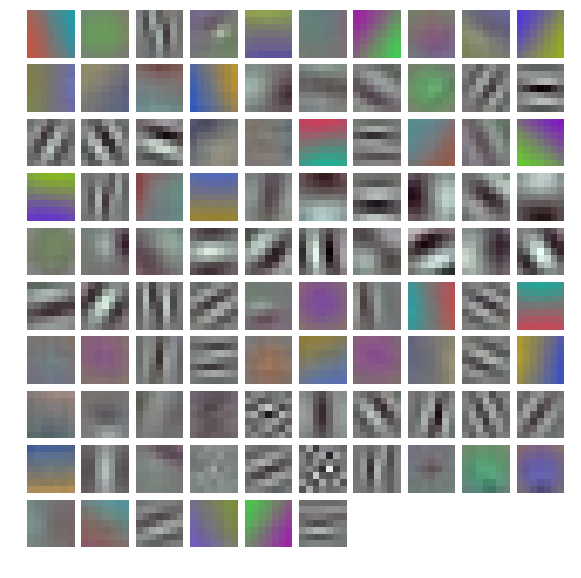

In [106]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

In [118]:
feat = net.blobs['pool3'].data[0]
vis_square(feat[:, :])

KeyError: 'pool3'

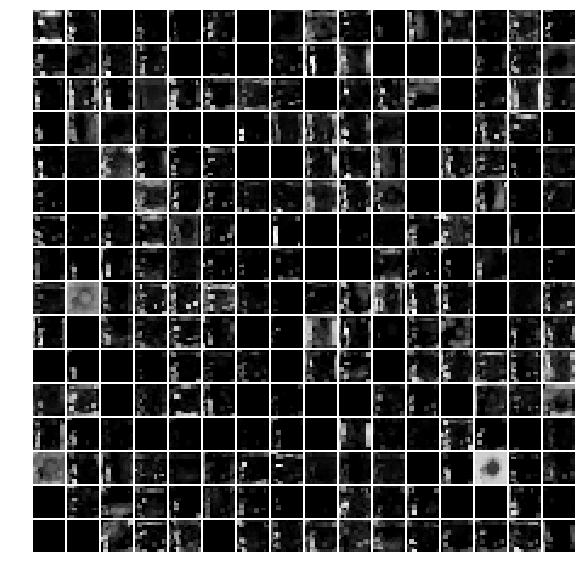

In [112]:
feat = net.blobs['pool2'].data[0]
vis_square(feat)

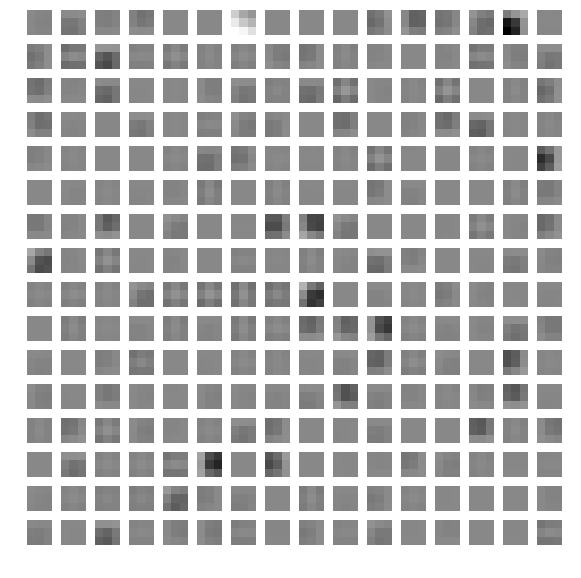

In [115]:
filters = net.params['conv5_ratsi'][0].data
vis_square(filters.transpose(0, 2, 3, 1)[:,:,:,1])